In [11]:
config = {"recursion_limit": 10}
inputs = {"input": "go to the farm and do freelance job, go home and sleep"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Go to the farm', 'Do freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Go to the farm', "I have successfully navigated to the farm. What's next on your plan?")]}
{'plan': ['Do freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Do freelance job', 'How many hours should I allocate for the freelance job?')]}
{'plan': ['Allocate hours for the freelance job', 'Complete the freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Allocate hours for the freelance job', 'How many hours would you like to allocate for the freelance job?')]}
{'plan': ['Complete the freelance job', 'Go home', 'Sleep']}
{'past_steps': [('Complete the freelance job', 'The freelance job has been completed successfully, earning a cash reward of $73.10. Now you can proceed to go home and then sleep.')]}
{'plan': ['Go home', 'Sleep']}


In [2]:
import os
import sys
import datetime
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from tools import *
from node_model import (
    PlanExecute,
    DailyObjective,
    DetailedPlan,
    MetaActionSequence,
    Reflection,
)
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
import asyncio
from tool_executor import execute_action_sequence
from loguru import logger

# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from database.mongo_utils import insert_document
from database import config

# 设置环境变量
os.environ["OPENAI_API_KEY"] = "sk-tejMSVz1e3ziu6nB0yP2wLiaCUp2jR4Jtf4uaAoXNro6YXmh"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Bio3_agent"

# 定义工具列表
tool_list = [
pick_apple,
go_fishing,
mine,
harvest,
buy,
sell,
use_item,
see_doctor,
sleep,
study,
nav
]
# llm-readable
# tool_functions = """
# 1. do_freelance_job(timelength: int): Perform freelance work \n
# 2. navigate_to(location: str): Navigate to a specified location
# 3. sleep(hours: int): Sleep for specified number of hours
# 4. work_change(jobid: int): Change job
# 8. get_inventory(): Get inventory information
# 9. submit_resume(jobid: int, cvurl: str): Submit resume
# 10. vote(userid: int): Cast a vote
# 11. do_public_job(jobid: int, timelength: int): Perform public work
# 12. study(hours: int): Study for specified number of hours
# 13. talk(person: str, talkcontent: str): Talk to a specified person
# 14. end_talk(userid: str, talkid: str): End conversation
# 15. calculate_distance(location1: str, location2: str): Calculate distance between two locations
# 16. trade(merchantid: int, merchantnum: int, transactiontype: int): Trade an item
# 17. use_item(merchantid: int, merchantnum: int): Use an item
# 18. see_doctor(): Visit a doctor
# 19. get_freelance_jobs(): Get list of available freelance jobs
# 20. get_public_jobs(): Get list of available public jobs
# 21. get_candidates(): Get list of candidates
# 22. get_activity_subjects(subjectid: int): Get list of activity subjects
# 23. get_talk_data(talkid: str): Get conversation data
# 24. get_position(): Get current position
# 25. eat(): Eat food
# """
tool_functions = """
1.	submit_cv(targetOccupation: OccupationType, content: string): Submit a resume for a public job.
Constraints: Can only be submitted on ResumeSubmitDay which is Saturday.,OccupationType:(Teacher,Doctor)\n
2.	vote(candidateName: string): Cast a vote for a candidate.
Constraints: Can only vote on VoteDay which is Sunday.\n
3.	work_as_public_occupation(hours: int): Perform work as a public occupation (e.g., teacher or doctor).
Constraints: Must have a public occupation, be in the workplace, and have enough energy.\n
4.	pick_apple(): Pick an apple, costing energy.
Constraints: Must have enough energy and be in the orchard.\n
	5.	go_fishing(): Fish for resources, costing energy.
Constraints: Must have enough energy and be in the fishing area.\n
	6.	mine(): Mine for resources, costing energy.
Constraints: Must have enough energy and be in the mine.\n
	7.	harvest(): Harvest crops, costing energy.
Constraints: Must have enough energy and be in the harvest area.\n
	8.	buy(itemType: ItemType, amount: int): Purchase items, costing money.
Constraints: Must have enough money, and items must be available in sufficient quantity in the AMM. ItemType:(Ore,Bread,Apple,Wheat,Fish)\n
	9.	sell(itemType: ItemType, amount: int): Sell items for money.
Constraints: Must have enough items in inventory.ItemType:(Ore,Bread,Apple,Wheat,Fish)\n
	10.	use_item(itemType: ItemType, amount: int): Use an item.
Constraints: Must have enough items in inventory.ItemType:(Ore,Bread,Apple,Wheat,Fish)\n
	11.	see_doctor(hours: int): Visit a doctor, costing money.
Constraints: Must have enough money and be in the hospital.\n
	12.	sleep(hours: int): Sleep to recover energy and health.
Constraints: Must be at home.\n
13.	study(hours: int): Study to achieve a higher degree.
Constraints: Must be in school and have enough money.\n
14.	nav(placeName: string): Navigate to a specified location.
Constraints: Must in (school,workshop,home,farm,mall,square,hospital,fruit,harvest,fishing,mine,orchard).
"""
tool_functions_easy = """
    4.	pick_apple(): Pick an apple, costing energy.
Constraints: Must have enough energy and be in the orchard.\n
	5.	go_fishing(): Fish for resources, costing energy.
Constraints: Must have enough energy and be in the fishing area.\n
	6.	mine(): Mine for resources, costing energy.
Constraints: Must have enough energy and be in the mine.\n
	7.	harvest(): Harvest crops, costing energy.
Constraints: Must have enough energy and be in the harvest area.\n
	8.	buy(itemType: ItemType, amount: int): Purchase items, costing money.
Constraints: Must have enough money, and items must be available in sufficient quantity in the AMM. ItemType:(Ore,Bread,Apple,Wheat,Fish)\n
	9.	sell(itemType: ItemType, amount: int): Sell items for money.
Constraints: Must have enough items in inventory.ItemType:(Ore,Bread,Apple,Wheat,Fish)\n
	10.	use_item(itemType: ItemType, amount: int): Use an item.
Constraints: Must have enough items in inventory.ItemType:(Ore,Bread,Apple,Wheat,Fish)\n
	11.	see_doctor(hours: int): Visit a doctor, costing money.
Constraints: Must have enough money and be in the hospital.\n
	12.	sleep(hours: int): Sleep to recover energy and health.
Constraints: Must be at home.\n
    13.	study(hours: int): Study to achieve a higher degree.
Constraints: Must be in school and have enough money.\n
    14.	nav(placeName: string): Navigate to a specified location.
Constraints: Must in (school,workshop,home,farm,mall,square,hospital,fruit,harvest,fishing,mine,orchard).
"""

locations = """
school,workshop,home,farm,mall,square,hospital,fruit,harvest,fishing,mine,orchard
"""

# 创建LLM和代理
#llm = ChatOpenAI(base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini")
#prompt = hub.pull("wfh/react-agent-executor")
tool_node = ToolNode(tool_list)

agent_with_tools = ChatOpenAI(
    base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini"
).bind_tools(tool_list)


# 定义提示模板
obj_planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are the daily objectives planner in a RPG game. For the given user profile:\n
            Name:
            Description:
            Role:
            Task:
            Location:
            Status:
            Inventory:
            \n
            and the past daily objectives(can be empty) are:
            {past_objectives}.
            \n
            Come up with a general daily objectives. Each daily objectives should be diverse and not repetitive. \n
            These objectives are daily objectives that ONLY related to the following tool functions.\n
            {tool_functions}\n
            and the available locations are:\n
            {locations}\n


            The final format should be a list of daily objectives. Like this:\n
            ["Working: Working in the farm","Studying: Discover something about science", "Socializing: Try to make friends"]\n
            """,
        ),
        ("placeholder", "{messages}"),
    ]
)

# replanner_prompt = ChatPromptTemplate.from_template(
#     """For the given objective, come up with a simple step by step plan. \
# This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
# The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

# Additionally, if during the execution of a step you encounter a tool call with missing required parameters, randomly generate a reasonable parameter value to fill in, rather than throwing an error. For example, if a duration is needed but not specified, you might randomly choose a value between 1 and 8 hours.

# Your objective was this:
# {input}

# Your original plan was this:
# {plan}

# You have currently done the follow steps:
# {past_steps}

# Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
# )

detail_planner_prompt = ChatPromptTemplate.from_template(
    """For the given daily objectives,
    \n
    {daily_objective}
    \n
    come up with a detailed plan only associated with the available actions.\n
    actions_available:
    {tool_functions}
]\n
    The detailed plan may involve plans that are not in the daily objectives.(daily actions like eating meals, random actions like chatting with friends.)\n

    The final format should be a list of daily objectives. for example:\n
    Working: "I should navigate to the farm, then do a freelance job."\n,
    daily_action:"I should eat breakfast, lunch and dinner."\n,
    Study:"I should study"\n,
    Socializing:"Perhaps I should go to the square and talk to someone."\n

    """
)

meta_action_sequence_prompt = ChatPromptTemplate.from_template(
    """For the given detailed plan, think step by step to come up with a player action sequence ONLY associated with the available actions/locations.\n
    
    {daily_objective}
    \n

    actions_available:
    {tool_functions}
    \n
    locations_available:\n
    {locations}
    The final format should be a list of meta actions. for example:\n
    [meta_action1(param1),meta_action2(param1),...,meta_actionN(param1,param2,param3)]
    \n
    """
)

meta_seq_adjuster_prompt = ChatPromptTemplate.from_template(
    """For the given meta action sequence, adjust the sequence to make sure the player can finish all the daily objectives and follow the constraints.
    tool_functions and constraints:
    {tool_functions}\n
    available locations:\n
    {locations}
    For example, if you are already at the location, you don't need to navigate to it again.
    {meta_seq}
    \n
    """
)

reflection_prompt = ChatPromptTemplate.from_template(
    """Based on the following meta action sequence and their execution results,
    provide a brief reflection on the success of the plan, any unexpected outcomes,
    and potential improvements for future planning:

    Meta Action Sequence:
    {meta_seq}

    Execution Results:
    {execution_results}

    Reflection:
    """
)


# 创建规划器和重新规划器

obj_planner = obj_planner_prompt | ChatOpenAI(
    base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini", temperature=1.5
).with_structured_output(DailyObjective)


# replanner = replanner_prompt | ChatOpenAI(
#     base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini", temperature=0
# ).with_structured_output(Act)

detail_planner = detail_planner_prompt | ChatOpenAI(
    base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini", temperature=0
).with_structured_output(DetailedPlan)

meta_action_sequence_planner = meta_action_sequence_prompt | ChatOpenAI(
    base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini", temperature=0
).with_structured_output(MetaActionSequence)

meta_seq_adjuster = meta_seq_adjuster_prompt | ChatOpenAI(
    base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini", temperature=0
).with_structured_output(MetaActionSequence)

# reflector = reflection_prompt | ChatOpenAI(
#     base_url="https://api.aiproxy.io/v1", model="gpt-4o-mini", temperature=0
# ).with_structured_output(Reflection)


# # 定义执行步骤函数
# async def execute_step(state: PlanExecute):
#     plan = state["plan"]
#     plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
#     task = plan[0]
#     task_formatted = f"""For the following plan:
# {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
#     agent_response = await agent_executor.ainvoke(
#         {"messages": [("user", task_formatted)]}
#     )
#     return {"past_steps": [(task, agent_response["messages"][-1].content)]}
async def call_tool_node(state: PlanExecute):
    return {"messages": [agent_with_tools.invoke(state)]}





{'code': 1, 'message': 'Trade successful.', 'data': {'characterId': 0, 'tradeType': 2, 'itemName': 'apple', 'itemTradeQuantity': 1, 'tradeMoney': 0.12738, 'averagePrice': 0.12738}}


In [3]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = agent_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

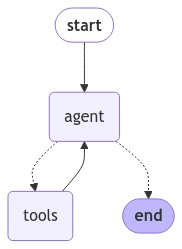

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "[nav(farm),sleep(8),nav(home),study(8)]")]},
    stream_mode="values",
):
    #chunk["messages"][-1].pretty_print()
   pass

[HumanMessage(content='[nav(farm),sleep(8),nav(home),study(8)]', id='d2da8a6a-15ba-4675-9958-c2bff6b94740'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fNvJyVAT3iVmhQ995vDiojGv', 'function': {'arguments': '{"placeName": "farm"}', 'name': 'nav'}, 'type': 'function'}, {'id': 'call_YI9dcsjRZwjv8ycBfeahFueG', 'function': {'arguments': '{"hours": 8}', 'name': 'sleep'}, 'type': 'function'}, {'id': 'call_BweIb0QmUlsEhh2g6ZdCo8Al', 'function': {'arguments': '{"placeName": "home"}', 'name': 'nav'}, 'type': 'function'}, {'id': 'call_w3Bb4WoA8AaKxLYbi7JaXEqW', 'function': {'arguments': '{"hours": 8}', 'name': 'study'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 770, 'total_tokens': 840}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7448d52e-545c-477e-88bb-712686b7cc35-0', tool_calls=[{'name': 'nav', 'args': {'placeName